# Transfer Learning with TensorFlow, Fine-Tuning

In [1]:
# Check for GPU 
!nvidia-smi

Tue Sep 13 19:38:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrithe them all. This is tedious though.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2022-09-13 19:38:30--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-09-13 19:38:31 (48.6 MB/s) - ‘helper.py’ saved [10235/10235]



In [3]:
# Import helper functions we are going to use in this notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

Using the pretrained models within `tf.keras.applications`

[link here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
# Get 10% of trainig data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-09-13 19:38:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   261MB/s    in 0.6s    

2022-09-13 19:38:34 (261 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

# Using image data from directory, all in one hit, no need for image_datagen instance
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Means that the labels are encoded as a categorical vector (for `categorical_crossentropy` loss), for multiclass data 
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# tf have turned the data into batches(BatchDataset)
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

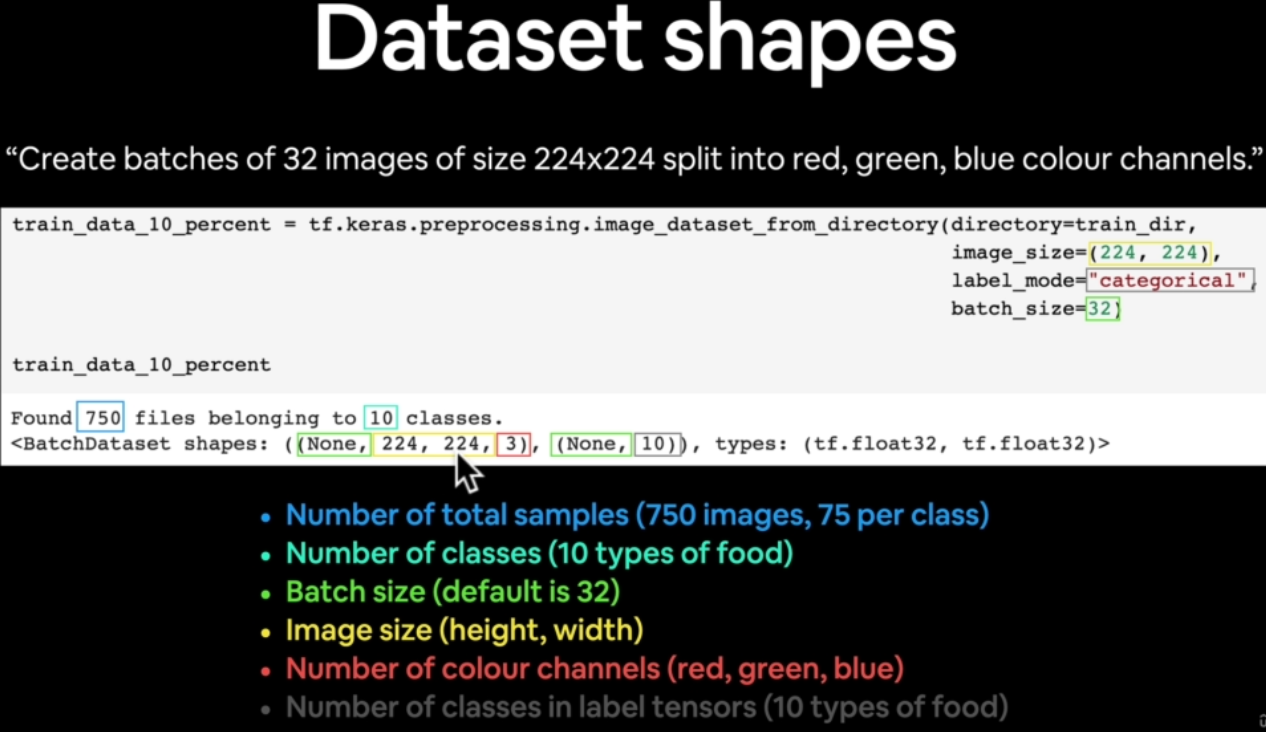

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.29760208e+02 1.27760201e+02 2.67602043e+01]
   [2.34617340e+02 1.31617340e+02 3.06173458e+01]
   [2.30290817e+02 1.23862244e+02 2.39234676e+01]
   ...
   [2.52192936e+01 1.42192926e+01 9.79076481e+00]
   [1.74081211e+01 9.76532841e+00 6.62244511e+00]
   [1.25152235e+01 9.58675671e+00 6.22957945e+00]]

  [[2.11566330e+02 1.11637749e+02 1.34234676e+01]
   [2.05066315e+02 1.02137749e+02 6.78060913e+00]
   [2.04658157e+02 9.90867310e+01 6.94387579e+00]
   ...
   [2.51020374e+01 1.41020374e+01 9.67350960e+00]
   [1.56478815e+01 8.00508976e+00 4.86220646e+00]
   [9.35707283e+00 6.42860603e+00 3.07142830e+00]]

  [[1.90484695e+02 9.06989822e+01 3.77040768e+00]
   [1.86056122e+02 8.50561142e+01 0.00000000e+00]
   [1.87096939e+02 8.23316269e+01 0.00000000e+00]
   ...
   [2.16632347e+01 1.22806196e+01 6.59187031e+00]
   [1.75713882e+01 9.78571415e+00 6.71427250e+00]
   [1.26428223e+01 9.69902706e+00 5.98981571e+00]]

  ...

  [[2.49642853e+02 1.61071381e+02 0.00000000e+00]
   [2

In [11]:
# Creating a model

ResNet152 = tf.keras.applications.resnet.ResNet152(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   classes=10)

234708992/234698864 [==============================] - 15s 0us/step


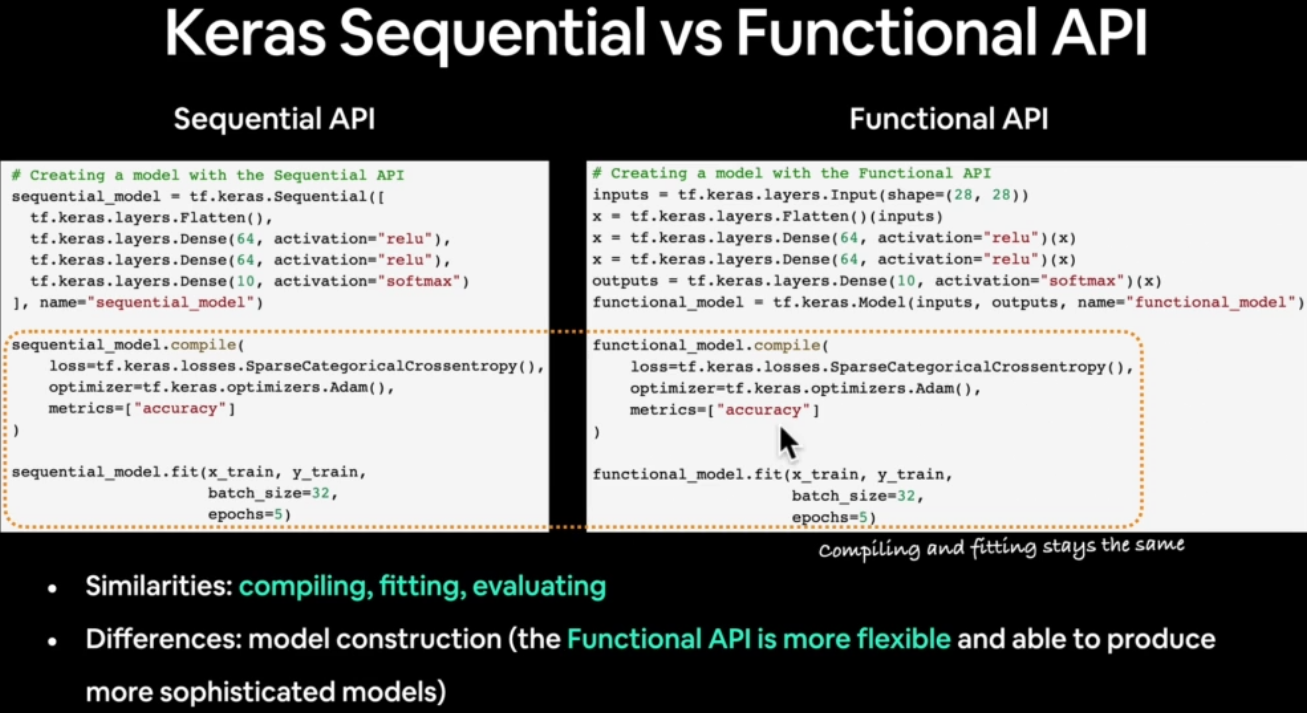

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequentinal API is straight-forward, it runs our layers in sequntial order.

But the functional API gives us more flexibility with our models

In [12]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)

# 2. Freeze the base model (so the underlaying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs 
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Avarage pool the outputs of the base model (aggregate all the most important information, reduce number of computatons)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 *len(test_data)), # Only 25% of the test data for faster training                              )
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="model_0_10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_10_percent_feature_extraction/20220913-193904
Epoch 1/5
24/24 [==============================] - 25s 367ms/step - loss: 1.9328 - accuracy: 0.3907 - val_loss: 1.3571 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 4s 154ms/step - loss: 1.1620 - accuracy: 0.7400 - val_loss: 0.9346 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 4s 152ms/step - loss: 0.8370 - accuracy: 0.7960 - val_loss: 0.7582 - val_accuracy: 0.7993
Epoch 4/5
24/24 [==============================] - 4s 151ms/step - loss: 0.6952 - accuracy: 0.8360 - val_loss: 0.6759 - val_accuracy: 0.8224
Epoch 5/5
24/24 [==============================] - 4s 152ms/step - loss: 0.6002 - accuracy: 0.8587 - val_loss: 0.6299 - val_accuracy: 0.8273


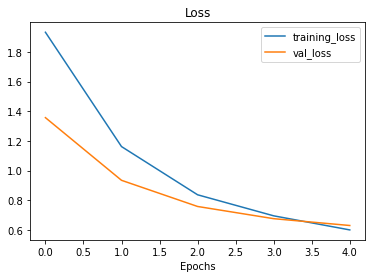

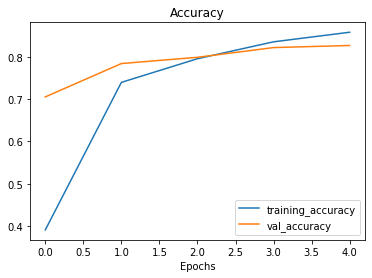

In [13]:
plot_loss_curves(history_model_0)

In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.6072 - accuracy: 0.8432


[0.6071863770484924, 0.8432000279426575]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [16]:
# Summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [17]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [18]:
# GlobalAveragePooling2D is transforming a 4d tensor into a 2d tensor

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")
print("It removes the two inner-axis:es")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)
It removes the two inner-axis:es


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2]) # the same result as in the above cell

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### ⚒**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` and see what happens.

In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_shape}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.MaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the differet tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 (1, 4, 4, 3)

2D global max pooled random tensor:
 [[[[ 0.8504023  -0.40604794  0.3194337 ]
   [ 0.9058464   0.539707    1.6994323 ]]

  [[ 0.77852213  0.4012578   0.97772694]
   [ 0.32410017  1.1603122   0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 2, 2, 3)


🔑**Note:** One of the reasons feature extractiontransfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers wich represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) wich can then be used to extract patterns out of for our own specific problem.

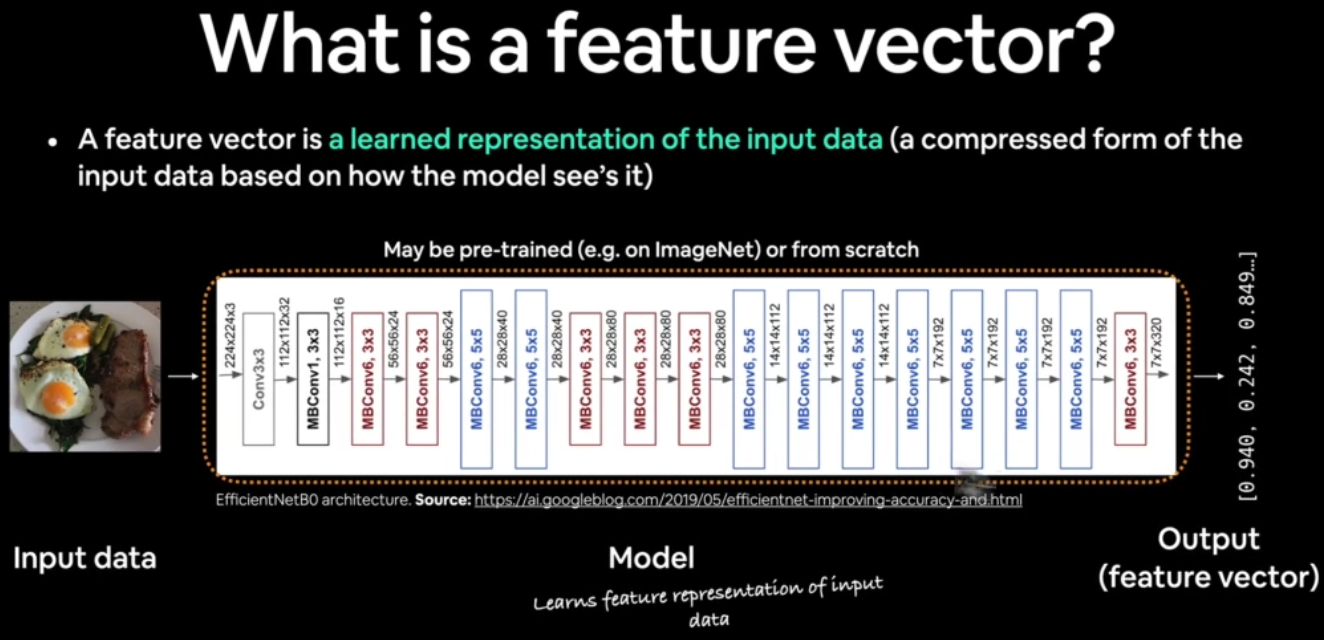

## Running a series of transfer learning exprimerients

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data? How about setting up a bunch of exeriments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning an 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model, this ensures consistency across evaluation metrics.

### Getting and preprocessing data for `model_1`

In [21]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-09-13 19:39:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   250MB/s    in 0.5s    

2022-09-13 19:39:58 (250 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# Create training and test data
train_dir_1_percent= "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [23]:
# Inspect how many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [24]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation [documentation](https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers)

Benefits:
* Preprocessing (augmenting) happens on the GPU = faster.
* Image data augmentation only happens during training, allowing us to export the whole model and us it elsewhere.

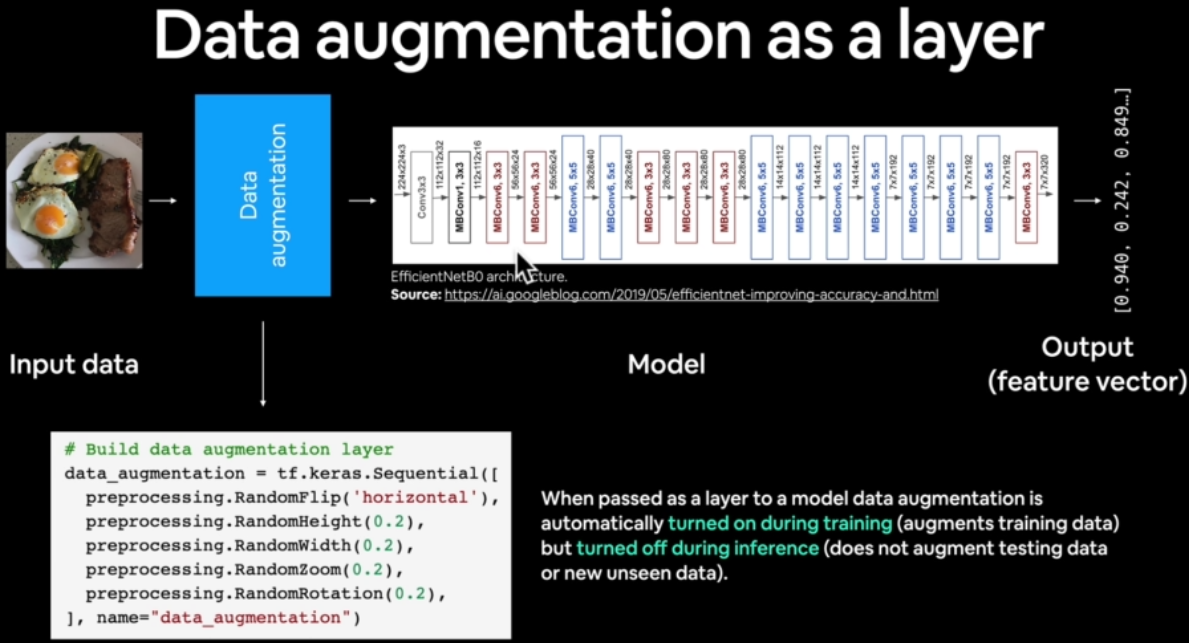

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficentNet's having rescaling built-in
], name="data_augmentation")

## Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 453.5, 536.5, -0.5)

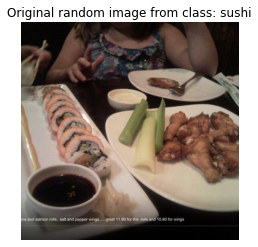

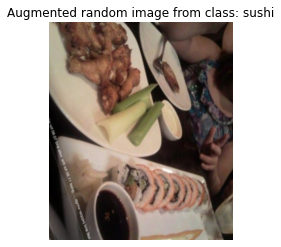

In [26]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Plot the augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [27]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
histrory_1_percent = model_1.fit(train_data_1_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_1_percent),
                       validation_data=test_data,
                       validation_steps=int(0.25 * len(test_data)),
                       # Track model training logs
                       callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220913-194003
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3898 - accuracy: 0.1000

3/3 [==============================] - 11s 2s/step - loss: 2.3898 - accuracy: 0.1000 - val_loss: 2.2343 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1482 - accuracy: 0.2286 - val_loss: 2.1172 - val_accuracy: 0.2516
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9612 - accuracy: 0.4000 - val_loss: 2.0442 - val_accuracy: 0.2845
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8660 - accuracy: 0.4429 - val_loss: 1.9547 - val_accuracy: 0.3602
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6983 - accuracy: 0.6143 - val_loss: 1.8785 - val_accuracy: 0.3997


In [29]:
# Check out model_1 summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 1.8430 - accuracy: 0.4084


[1.8429830074310303, 0.4083999991416931]

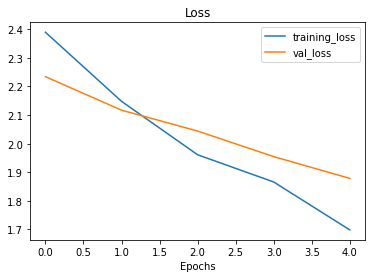

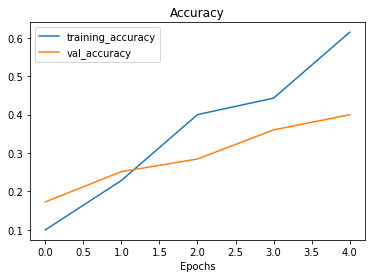

In [31]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(histrory_1_percent)

## Getting and preprocessing data for `model_2`

In [32]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-09-13 19:40:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   264MB/s    in 0.6s    

2022-09-13 19:40:38 (264 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [33]:
# Create training and test data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [34]:
# Inspect how many images we are working with
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [35]:
# Setup data loaders
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [36]:
# Create data augmentation layer
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # If you're using a model such as ResNet rescaling is built in
], name="data_augmentation")

## Visualize the augmented data

(-0.5, 442.5, 451.5, -0.5)

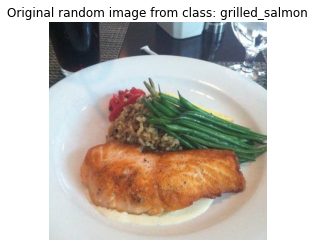

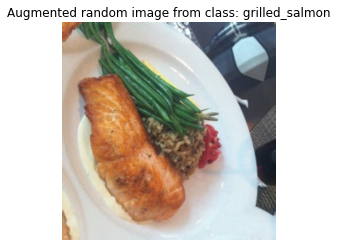

In [37]:
# View a random image and compare it to its augmented version
target_class = random.choice(train_data_10_percent.class_names)
target_dir = "10_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Plot the augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [38]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [39]:
# Setup input shape and base model, freeze the layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequentinal model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Creatig a `ModelCheckpoint` callback

The `ModelCheckpoint`callback intermediatly saves our model (the full model or just the weights) during training. Tis is useful so we can come back and start wherre we left off.

In [40]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

## Fit `model_2` with checkpoint_callback

In [41]:
# Fit the model
history_10_percent = model_2.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_data_aug"),
                                            checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220913-194043
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 2.0419 - accuracy: 0.3173


Epoch 1: val_loss improved from inf to 1.49741, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 495ms/step - loss: 2.0419 - accuracy: 0.3173 - val_loss: 1.4974 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3644 - accuracy: 0.6893
Epoch 2: val_loss improved from 1.49741 to 1.08543, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 416ms/step - loss: 1.3644 - accuracy: 0.6893 - val_loss: 1.0854 - val_accuracy: 0.7615
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.7387
Epoch 3: val_loss improved from 1.08543 to 0.87741, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 412ms/step - loss: 1.0796 - accuracy: 0.7387 - val_loss: 0.8774 - val_accuracy: 0.7878
Epoch 4/5
24/24 [==============================] - ETA:

In [42]:
# Evaluate on the full test dataset
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.6961 - accuracy: 0.8072


[0.6961306929588318, 0.807200014591217]

In [43]:
# Compare with model_0 (the baseline model)
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.6072 - accuracy: 0.8432


[0.6071863174438477, 0.8432000279426575]

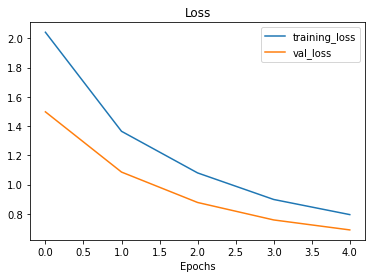

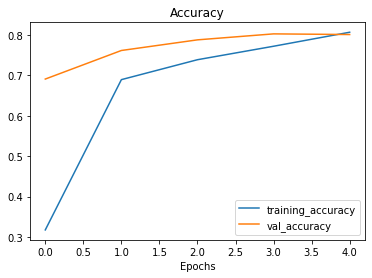

In [44]:
# Plot the loss curves
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [45]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [46]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6961 - accuracy: 0.8072


In [47]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked^^
results_10_percent_data_aug == loaded_weights_model_results

True

In [48]:
results_10_percent_data_aug

[0.6961306929588318, 0.807200014591217]

In [49]:
loaded_weights_model_results

[0.6961306929588318, 0.807200014591217]

In [50]:
# Check to se if loaded model results are very close to ourprevious non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [51]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


The difference between the results are "good enough", the difference depends on how computers store numbers. When in doubt use `np.isclose()` to see if the result is acceptable.

## Model_3: Fine_tuing an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

### Usually the layers towards the end of the model gets unfrezzed

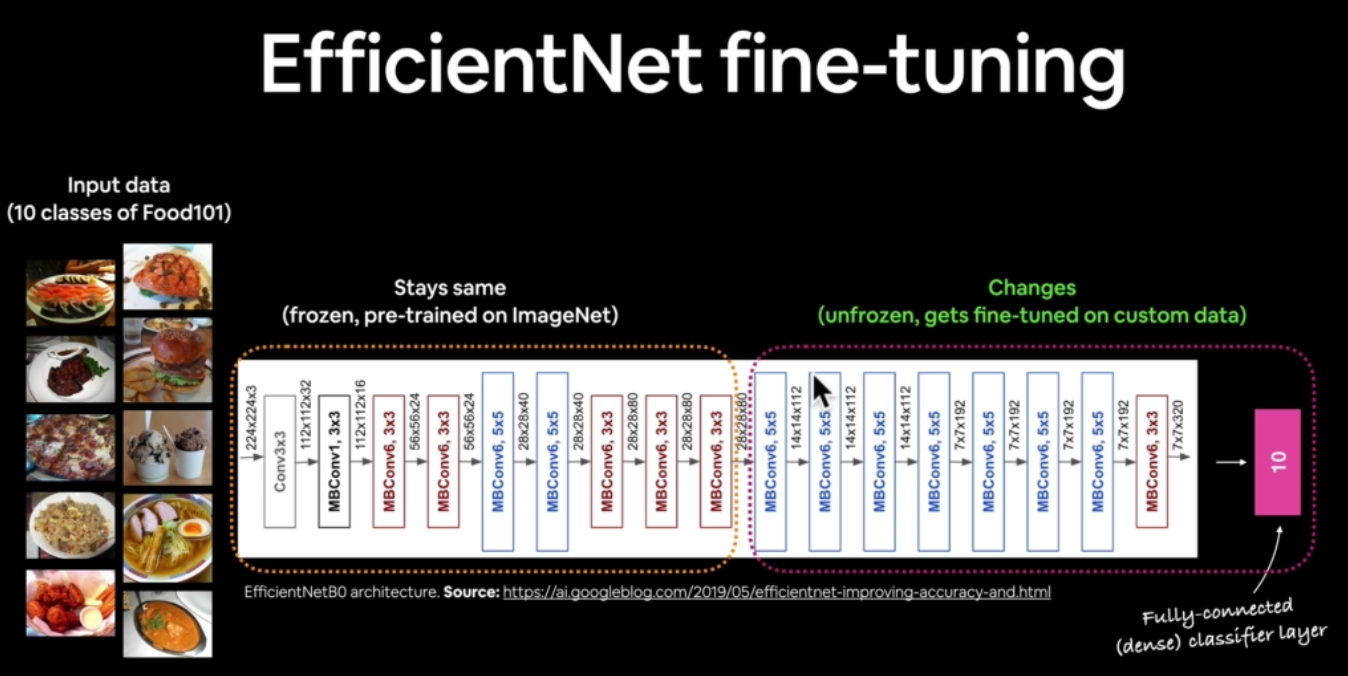

In [52]:
# Layers in our loaded model
model_2.layers

In [53]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0c2db13990> True
<keras.engine.sequential.Sequential object at 0x7f0c2dd56c90> True
<keras.engine.functional.Functional object at 0x7f0c2d716e90> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0c2dbba410> True
<keras.layers.core.dense.Dense object at 0x7f0c2db17310> True


In [54]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [56]:
# To begin fine_tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # When u fine tune, rule of thumb is to lower the learning rate by 10x
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


🔑**Note:** Whe using fine-tuning it's best prectice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
Agood resource for information on this is the ULMFiT paper: [link](https://arxiv.org/abs/1801.06146)

In [57]:
# Check wich layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [58]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [59]:
initial_epochs = 5
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model ( same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10_layers")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20220913-194216
Epoch 5/10


24/24 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.8200

24/24 [==============================] - 19s 521ms/step - loss: 0.6795 - accuracy: 0.8200 - val_loss: 0.5673 - val_accuracy: 0.8257
Epoch 6/10
24/24 [==============================] - 8s 331ms/step - loss: 0.5499 - accuracy: 0.8293 - val_loss: 0.5417 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 9s 358ms/step - loss: 0.4771 - accuracy: 0.8533 - val_loss: 0.5245 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 8s 323ms/step - loss: 0.4439 - accuracy: 0.8587 - val_loss: 0.5008 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 10s 387ms/step - loss: 0.3934 - accuracy: 0.8827 - val_loss: 0.4968 - val_accuracy: 0.8355
Epoch 10/10
24/24 [==============================] - 9s 341ms/step - loss: 0.3583 - accuracy: 0.9013 - val_loss: 0.4771 - val_accuracy: 0.8438


In [60]:
# Evaluate the fine-tuned model (model_3 wich is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4891 - accuracy: 0.8332


In [61]:
results_10_percent_data_aug

[0.6961306929588318, 0.807200014591217]

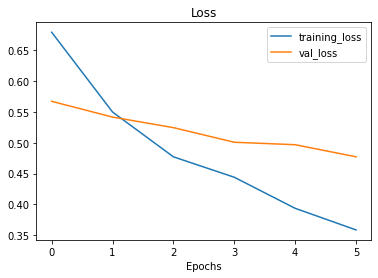

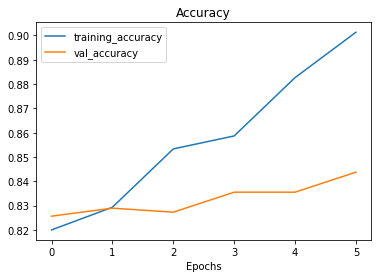

In [62]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The ´plot_loss_curves`function works great with models wich have only been fit once, however, we want something to compare on series of running `fit()` with another (e.g. before and after fine-tuning).

In [63]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Trainig Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Trainig Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

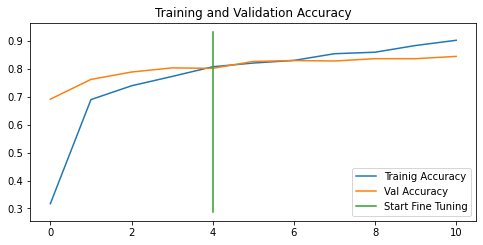

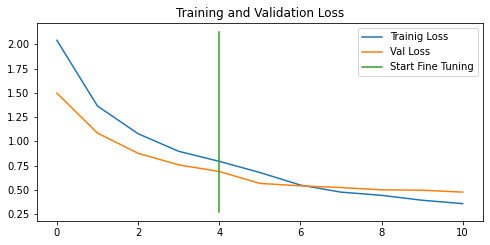

In [64]:
compare_historys(history_10_percent,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [65]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-09-13 19:43:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  59.9MB/s    in 8.3s    

2022-09-13 19:43:42 (59.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [66]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [67]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [68]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this..


In [69]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4891 - accuracy: 0.8332


[0.4891406297683716, 0.8331999778747559]

In [70]:
results_fine_tune_10_percent

[0.4891406297683716, 0.8331999778747559]

To train a fine-tuning model (`model_4`) we need to revert `model_2`back to its feature extraction weights.

In [71]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from.
model_2.load_weights(checkpoint_path)

In [72]:
# To verify that the weights have been loaded back (should be worse than "results_fine_tune_10_percent")
model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6961 - accuracy: 0.8072


[0.6961307525634766, 0.807200014591217]

In [73]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6961306929588318, 0.807200014591217]

## Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (`model_2`) and we saved the model's weights using `ModelCheckpoint`callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (`model_3`).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (`model_4`).

In [74]:
# Chack wich layers are tunabe in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [75]:
# Let's drill into our base_model (efficientnetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [76]:
# Re-compile the model to get it to work
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [77]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220913-194406
Epoch 5/10


235/235 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.7667

235/235 [==============================] - 60s 227ms/step - loss: 0.7289 - accuracy: 0.7667 - val_loss: 0.3821 - val_accuracy: 0.8734
Epoch 6/10
235/235 [==============================] - 49s 205ms/step - loss: 0.5886 - accuracy: 0.8119 - val_loss: 0.3758 - val_accuracy: 0.8783
Epoch 7/10
235/235 [==============================] - 42s 179ms/step - loss: 0.5181 - accuracy: 0.8316 - val_loss: 0.3334 - val_accuracy: 0.8980
Epoch 8/10
235/235 [==============================] - 40s 167ms/step - loss: 0.4705 - accuracy: 0.8477 - val_loss: 0.3053 - val_accuracy: 0.8898
Epoch 9/10
235/235 [==============================] - 39s 166ms/step - loss: 0.4417 - accuracy: 0.8567 - val_loss: 0.3453 - val_accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 37s 155ms/step - loss: 0.4147 - accuracy: 0.8667 - val_loss: 0.3062 - val_accuracy: 0.9046


In [78]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 73ms/step - loss: 0.3096 - accuracy: 0.8968


[0.30963030457496643, 0.8967999815940857]

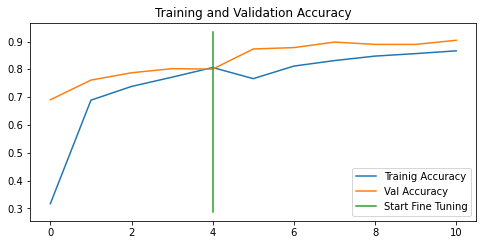

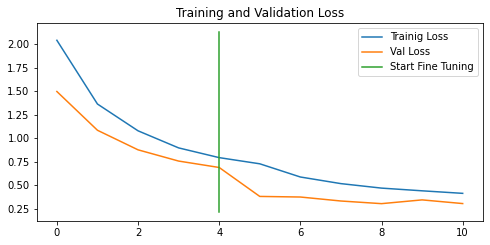

In [79]:
# How did fine_tuning go with more data?
compare_historys(original_history=history_10_percent,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.



In [80]:
# View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records
#\=new line
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader once its finished uploading


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


My TensorBoard experiments are avaliable [here](https://tensorboard.dev/experiment/Gvtx3UNzTx6Y8EZ2hAJDrw/)

In [81]:
# View all of your uploaded TensorBoard.dev experiments
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


In [82]:
# To delete an experiment
#!tensorboard dev delete --experiment_id

## **Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises**


1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.


## 1.

In [84]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [86]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation Sequentinal model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs, no training
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer as teh output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_extra = tf.keras.Model(inputs, outputs)

# Compile the model
model_extra.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [87]:
# Creating ModelCheckpoint callback
checkpoint_path = "model_extra_10_percent_checkpoints_weights/checkpoint.ckpt"

# Create a callback that saves the weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [91]:
# Fit model_extra with checkpoint_callback
history_model_extra = model_extra.fit(train_data_10_percent,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="Model_extra_10_percent_data_aug"),
                                            checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/Model_extra_10_percent_data_aug/20220913-202933
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8723 - accuracy: 0.4147


Epoch 1: val_loss improved from inf to 1.40929, saving model to model_extra_10_percent_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 314ms/step - loss: 1.8723 - accuracy: 0.4147 - val_loss: 1.4093 - val_accuracy: 0.6562
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3105 - accuracy: 0.6853
Epoch 2: val_loss improved from 1.40929 to 1.00748, saving model to model_extra_10_percent_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 254ms/step - loss: 1.3105 - accuracy: 0.6853 - val_loss: 1.0075 - val_accuracy: 0.7632
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.7320
Epoch 3: val_loss improved from 1.00748 to 0.82797, saving model to model_extra_10_percent_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 256ms/step - loss: 1.0476 - accuracy: 0.7320 - val_loss: 0.8280 - val_accuracy: 0.8092
Epoch 4/10
24/24 [=======================

In [92]:
# Evaluate te full test dataset
results_model_extra_data_aug = model_extra.evaluate(test_data)
results_model_extra_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.5634 - accuracy: 0.8300


[0.5634072422981262, 0.8299999833106995]

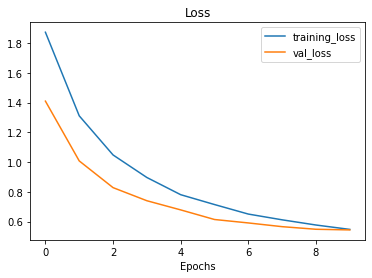

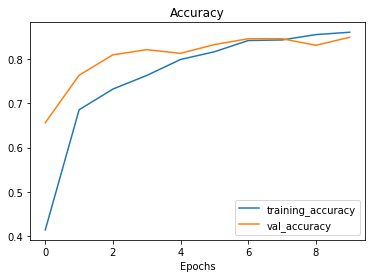

In [93]:
# Plot loss curves
plot_loss_curves(history_model_extra)

## 2.

In [94]:
# What layers are in base_model and are they trainable?
for i, layer in enumerate(model_extra.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [103]:
# Begin fine tuning, unfreeze the last 20 layers of model_extra
model_extra.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

# RECOMPILE EVERY TIME WE MAKE A CHANGE
model_extra.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower lr as u fine tune
                   metrics=["accuracy"])

In [104]:
# Check again wich layers are trainable (tunable)
for layer_number, layer in enumerate(model_extra.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [105]:
# How many trainable variables are there?
print(len(model_extra.trainable_variables))

21


## **Challange:** Recreate one of the experiments we did with the [EfficientNetB4 architecture in the tf.keras.applications module](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB4).